# Face Emotion Recognition (FER 2013)

In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Build dataset from images folders

In [46]:
def build_dataset(folder):
    """Function that returns a DataFrame of emotion + image inside a folder"""
    # List of folders names
    emotions = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
    # Dataframe
    df = pd.DataFrame(columns=["emotion","pixels"])
    for emotion in emotions:
        images = os.listdir(folder + "/" + emotion)
        for image_name in images :
            image = cv2.imread(folder + "/" + emotion + "/" + image_name) #ndarray	
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # ndarray
            # gray_list = np.reshape(gray, (1, -1)).tolist()[0]
            df2 = pd.DataFrame({"emotion":[emotion],"pixels":[gray]})
            df = pd.concat([df, df2], ignore_index=True)
    return df

In [47]:
df_train = build_dataset('./fer2013-archive/train')

In [48]:
df_test = build_dataset('./fer2013-archive/test')

## Normalization

In [50]:
def normalization(element):
    return element/255

df_train["pixels"] = df_train["pixels"].apply(normalization)
df_test["pixels"] = df_test["pixels"].apply(normalization)

## Convertir le DataFrame en ndarray

Nous convertissons le DataFrame en ndarray, au bonnes dimensions. Le ndarray doit avoir 4 dimensions : 
- le nombre d'exemples (ligne du tableau)
- les pixels en largeur
- les pixels en hauteur
- le nombre de couches (1 seule en niveau de gris, 3 en RVG)

In [51]:
# df_train.shape[0] est le nombre de lignes du DataFrame
X_train = np.reshape(df_train["pixels"].to_list(),(df_train.shape[0],48,48,1)) # ndarray
y_train = df_train["emotion"] # df

X_train.shape

(28709, 48, 48, 1)

In [52]:
X_test = np.reshape(df_test["pixels"].to_list(),(df_test.shape[0],48,48,1))
y_test = df_test["emotion"]

X_test.shape

(7178, 48, 48, 1)

In [28]:
# Dimensions
print("Dimensions de X_train : ", X_train.ndim)
print("Dimensions de X_test : ", X_test.ndim)

Dimensions de X_train :  4
Dimensions de X_test :  4


## Vérifier que le type de donnée dans ndarray est bien "float"

In [54]:
# View the data type of tensor
print(X_train.dtype)
print(X_test.dtype)

float64
float64


## Afficher une image et son émotion correspondante

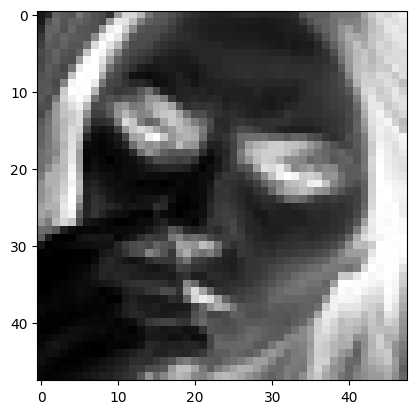

In [55]:
# Display an image
plt.imshow(X_train[2], cmap=plt.cm.binary)

In [56]:
# Display corresponding emotion
print(y_train[2])

fear


## Encoder les classes (cibles)

Nous utilisons la méthode pandas .get_dummies() pour effectuer un One-Hot encoding des différentes "émotions". Nous obtenons un DataFrame de ndarray qui compte le même nombre de colonnes que le nombre de nos "émotions".

In [57]:
emotions_map = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [58]:
y_train = pd.get_dummies(y_train.to_list(), columns=emotions_map)

In [61]:
y_test = pd.get_dummies(y_test.to_list(), columns=emotions_map)

In [62]:
# Converting DataFrame to ndarray
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [35]:
# Afficher y_train
print(y_train)

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

In [63]:
y_train.shape

(28709, 7)

## Réseau de neurones "Dense" dans Keras

In [65]:
import keras
from keras.models import Sequential
from keras.layers import Input,Dense, Activation, Flatten 

## Definir le modèle

In [66]:
model = Sequential()
model.add(Flatten(input_shape=(48, 48)))
model.add(Dense(2304, activation='relu', input_shape=(2304,)))
model.add(Dense(1000, activation='relu'))
model.add(Dense(7, activation='softmax')) # output layer

2023-01-31 09:33:13.582370: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/david/workspace/py-sql/venv/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-31 09:33:13.582867: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-31 09:33:13.582911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (UTILISA-DH7KBL7): /proc/driver/nvidia/version does not exist
2023-01-31 09:33:13.585135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with th

### Compiler le modèle avec la méthode .compile()

In [67]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])

### Entrainer le modèle avec la méthode .fit()

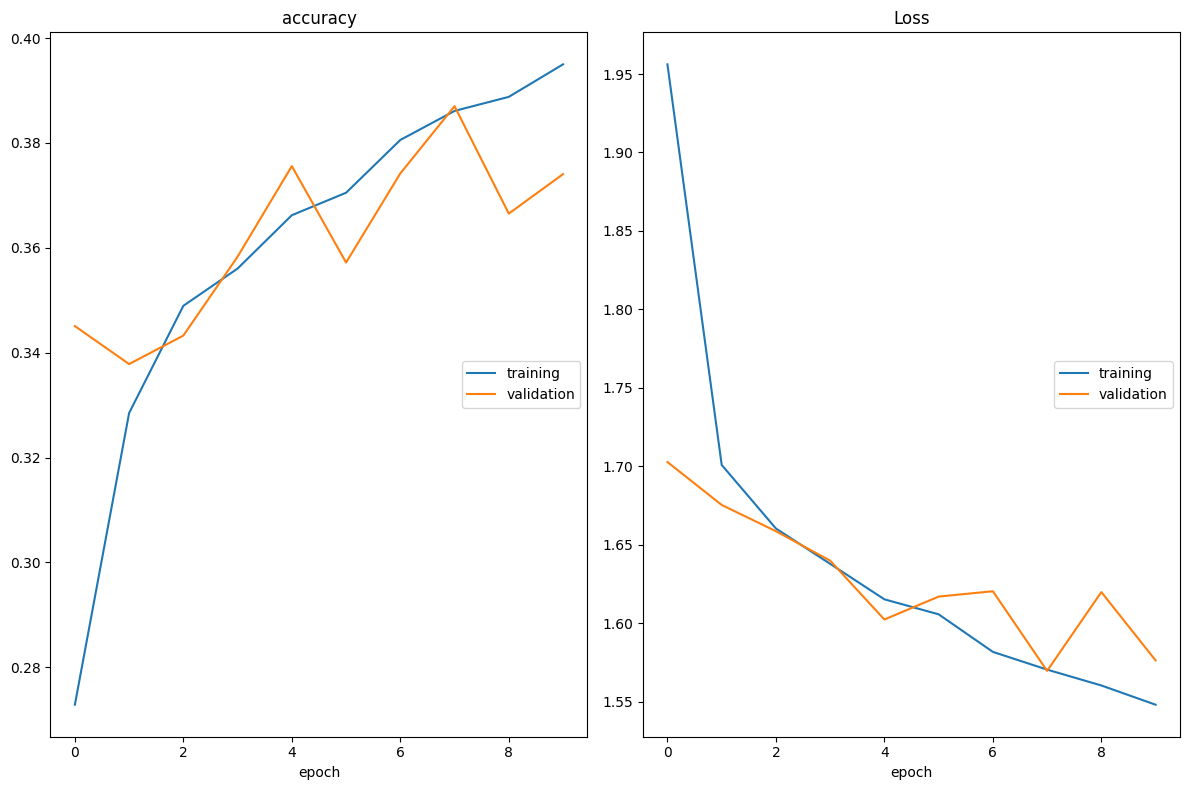

accuracy
	training         	 (min:    0.273, max:    0.395, cur:    0.395)
	validation       	 (min:    0.338, max:    0.387, cur:    0.374)
Loss
	training         	 (min:    1.548, max:    1.956, cur:    1.548)
	validation       	 (min:    1.570, max:    1.703, cur:    1.576)
288/288 [==============================] - 35s 122ms/step - loss: 1.5480 - accuracy: 0.3950 - val_loss: 1.5763 - val_accuracy: 0.3741


In [68]:
from livelossplot import PlotLossesKeras

model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=100, epochs=10, callbacks=[PlotLossesKeras()])

### Evaluer le modèle avec la méthode .evaluate()

In [69]:
test_loss, test_acc = model.evaluate(X_test, y_test)

225/225 [==============================] - 5s 22ms/step - loss: 1.5763 - accuracy: 0.3741


## Précision du modèle

In [70]:
print('Test accuracy:', round(test_acc,4))

Test accuracy: 0.3741


## Matrice de confusion

In [82]:
# Plot confusion matrix 
# Note: This code snippet for confusion-matrix is taken directly from the SKLEARN website.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')

225/225 [==============================] - 6s 25ms/step


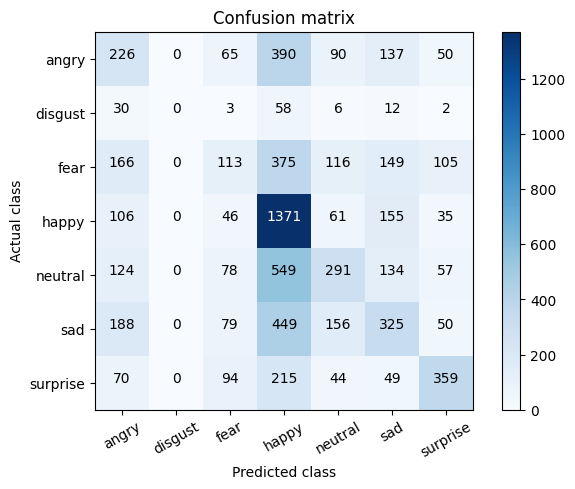

In [84]:
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = emotions_map)

## Génerer des predictions

In [85]:
predictions = model.predict(X_test)

225/225 [==============================] - 4s 20ms/step


In [74]:
# Prediction pour l'image de test numéro 12 :
np.argmax(predictions[11])

2

In [78]:
# Emotion correspondante
emotions_map[np.argmax(predictions[11])]

'fear'

In [80]:
print(predictions[11]) # ndarray

[0.1946053  0.02153601 0.24682643 0.19955318 0.05985814 0.10092209
 0.17669885]


In [81]:
np.sum(predictions[11])

1.0

## Exporter le modèle